# Preprocessing data (functionized)

## 1. Preparations
### 1.1 Import required packages

In [9]:
# import rasterio
try:
    import rasterio
except:
    %pip install rasterio
    import rasterio

import rasterio.features
import rasterio.warp
from rasterio.windows import Window
from rasterio.features import geometry_mask

In [24]:
import os
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

### 1.2 Set directories and file paths

In [14]:
# input directories
# raster data
gtif_dir = r"D:\Drohne\1_OHB\1_OHB_Normalbetrieb\3_OHB_Juli_2024\Outputs\RGB\GeoTIFF"
# class labels
shp_dir = r"C:\Users\simon\Meine Ablage\Dokumente.GD\FS06 SS24\BACHELORARBEIT\MoSE\data\shapefiles"

# output directories for patches
# as GeoTIFFs
output_gtif_dir = r"D:\MoSE\preprocessing\gtif_outputs"
# as NumpyArrays
output_nparr_dir = r"D:\MoSE\preprocessing\nparr_outputs"

## 2. Create Patches
### 2.1 Set Hyperparameters

In [54]:
# exact paths to files
# raster data
gtif_name = "A01"
gtif_path = gtif_dir + r"\OHB_Abschnitt_01.tif"
# class labels
shp_path = shp_dir + r"\GSK_24_WGS84.shp"

In [12]:
# parameters for patches
PATCH_SIZE = 512 # 512x512 pixel per patch
STRIDE = 256 # 256 pixel overlap between patches

### 2.2 Create the patch loop

In [ ]:
# 1. Load the GeoTIFF (orthophoto)
with rasterio.open(gtif_path) as src:
    nparr_data = src.read() # reads raster data of the GeoTIFF as NumPy-Array
    gtif_width, gtif_height = src.width, src.height
    gtif_transform = src.transform  # transformation matrix (whole image)
    gtif_crs = src.crs  # coordinate system
    gtif_meta = src.meta.copy() # original metadata like coordinate system, resolution, datatype
    gtif_bounds = src.bounds

    # 2. Load labels and transform in crs of the orthophoto
    labels = gpd.read_file(shp_path)
    labels = labels.to_crs(gtif_crs)

    # 3. LOOP for patches
    # set patch-id to zero
    patch_id = 0 # unique counter

    # Loop over the image in steps of STRIDE (overlapping patches if STRIDE < PATCH_SIZE)
    for y in range(0, gtif_height, STRIDE): # vertical movement y (start point: 0, end point: height, steps: STRIDE)
        for x in range(0, gtif_width, STRIDE): # horizontal movement x (start point: 0, end point: width, steps: STRIDE)
            
            # 3.1 Define window (patch)
            window = Window(x, y, PATCH_SIZE, PATCH_SIZE) 
            # defines a patch/window with origin (x, y) and a size of PATCH_SIZExPATCH_SIZE 

            # 3.2 Calculate the transformation matrix for this patch
            patch_transform = src.window_transform(window) 
            # this transformation matrix describes how the pixel coordinates of this window can be converted into 
            # the world coordinates of the image (geocoordinates)

            # 3.3 Extract raster data for the patch
            patch_data = src.read(window=window)
            # patch_data should be an array with shape [bands, PATCH_SIZE, PATCH_SIZE]
            
            # 3.4 Skip incomplete patches
            # if the calculated patch is partially outside the image boundaries (patch is smaller than PATCH_SIZE),
            # skip the patch to avoid errors
            if patch_data.shape[1] < PATCH_SIZE or patch_data.shape[2] < PATCH_SIZE:
                continue

            # 4. Create masks for the labels
            
            # 4.1 Calculate geographical coordinates (boundaries) of current patch 
            patch_bounds = rasterio.windows.bounds(window, gtif_transform) # with orthophoto transformation matrix 
            
            # 4.2 Filters label polygons which are inside the patch
            patch_labels = labels.cx[ # labels.cx (pandas) > filters geometries by coordinates
                patch_bounds[0]:patch_bounds[2],  # min_x:max_x
                patch_bounds[1]:patch_bounds[3],  # min_y:max_y
            ]

            # 4.3 Create mask
            mask = None # Reset mask
            if not patch_labels.empty: # if there are any labels in this patch 
                mask = geometry_mask( # creates binary mask (1 = inside polygon, 0 = outside)
                    [geom for geom in patch_labels.geometry], # list of geometries
                    transform=patch_transform, # transform matrix for this patch
                    invert=True, # pixel inside the geometries (labels) = 1, pixel outside (background) = 0
                    out_shape=(PATCH_SIZE, PATCH_SIZE), # size of the mask
                )

            # 5. Save patch
            # 5.1 Save meta data of the patch
            patch_meta = gtif_meta.copy()
            patch_meta.update({
                "height": PATCH_SIZE,
                "width": PATCH_SIZE,
                "transform": patch_transform,
            })

            # 5.2 Save patch as GeoTIFF
            patch_path = os.path.join(output_gtif_dir, f"{gtif_name}_patch_{patch_id}.tif")
            with rasterio.open(patch_path, "w", **patch_meta) as dst:
                dst.write(patch_data)  # orthophoto
                if mask is not None:
                    dst.write(mask.astype("uint8"), 1)  # label mask

            # 5.3 Save patch as NumpyArray
            npy_data = {"image": patch_data}
            if mask is not None:
                npy_data["mask"] = mask
            np.save(os.path.join(output_nparr_dir, f"{gtif_name}_patch_{patch_id}.npy"), npy_data)

            patch_id += 1
    print(f"{patch_id} Patches wurden erstellt und gespeichert in {output_gtif_dir}.")

KeyboardInterrupt: 

In [51]:
print(f"{patch_id} Patches wurden erstellt und gespeichert in {output_gtif_dir}.")

6336 Patches wurden erstellt und gespeichert in D:\MoSE\preprocessing\gtif_outputs.


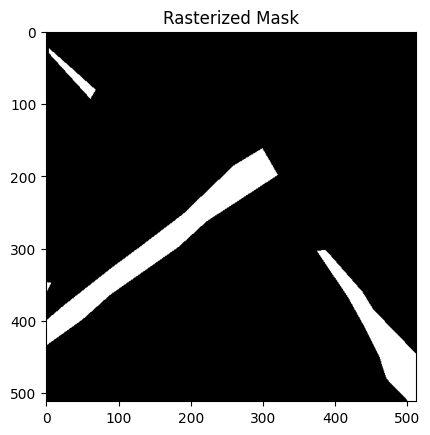

In [52]:
import matplotlib.pyplot as plt

plt.imshow(mask, cmap="gray")
plt.title("Rasterized Mask")
plt.show()


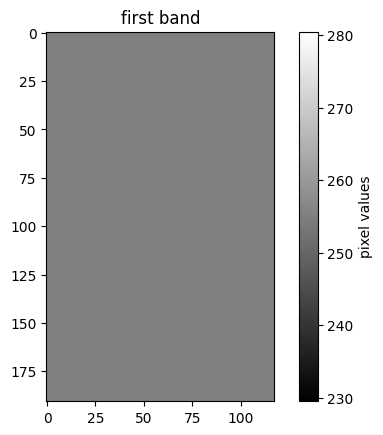

### 2.3 Check the orthophoto

In [ ]:
# check meta data
gtif_meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 17270,
 'height': 25023,
 'count': 4,
 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],TOWGS84[0,0,0,0,0,0,0],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'),
 'transform': Affine(3.2633900000001453e-07, 0.0, 11.263241617518593,
        0.0, -2.1580999999988398e-07, 48.750540169360406)}

In [22]:
# check shape and datatype of the data
gtif_data.shape, type(gtif_data), gtif_data.dtype

((4, 25023, 17270), numpy.ndarray, dtype('uint8'))

In [ ]:
# check geometrical properties
gtif_crs, gtif_bounds, gtif_height, gtif_width

(CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],TOWGS84[0,0,0,0,0,0,0],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'),
 BoundingBox(left=11.263241617518593, bottom=48.74513995573041, right=11.268877492048594, top=48.750540169360406),
 25023,
 17270)

In [26]:
# # plot the first band
# plt.imshow(gtif_data[0], cmap='gray')  # visalization with grey values
# plt.colorbar(label='pixel values')
# plt.title("first band")
# plt.show()